# Notebook: Analyzing annotations
This notebook is part of my Bachelor's Thesis for the Spanish Language and Culture program of Radboud University (Tesina de bachelor: filologia hispánica)

In [1]:
import os
import fnmatch
import copy
import unittest
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

In [2]:
def strToBool(row, col_name = 'has_a'):
    if row[col_name] == 'True' or row[col_name] == 'TRUE':
        return True
    else:
        return False

def strToInt(row):
    return int(row['year'][:4])

def combine_def(row):
    if isinstance(row['definiteness_cor'], str):
        new_def = "Definiteness." + row['definiteness_cor']
    else:
        new_def = row['definiteness']
    return new_def

def read_tsv_file(filename, filt = True):
    df = pd.read_csv(filename, dtype=str, sep='\t')
    if filt:
        mask = (df.loc[:, 'remove'].isnull()) & (~df.loc[:, 'animacy'].isnull())
        df = df[mask]
        definiteness = df.apply(combine_def, axis=1)
        df['corrected_def'] = definiteness
    df['has_a'] = df.apply(strToBool, axis=1)
    df['year'] = df.apply(strToInt, axis=1)
    return df

In [3]:
def find_files(root_folder='./parsed'):
    """
    Find all files in the BVC folder 
    Code from stack overflow: https://stackoverflow.com/questions/2186525/how-to-use-glob-to-find-files-recursively
    
    root_folder: the root folder for the files
    return: list of filenames in the root folder
    """
    
    matches = []
    for root, dirnames, filenames in os.walk(root_folder):
        for filename in fnmatch.filter(filenames, '*.tsv'):
            matches.append(os.path.join(root, filename))
    return matches

In [4]:
files = find_files()
print(files)


['./parsed/138annotated.tsv', './parsed/1010annotated.tsv', './parsed/90annotated.tsv', './parsed/8648annotated.tsv', './parsed/10107annotated.tsv', './parsed/23annotated.tsv', './parsed/164annotated.tsv', './parsed/449annotated.tsv', './parsed/8108annotated1554.tsv', './parsed/8784annotated.tsv']


In [5]:
# Make the dataframe with annotated files
for i, file in enumerate(files):
    print(file)
    if i == 0:
        df = read_tsv_file(file)
    else: 
        df = pd.concat([df, read_tsv_file(file)], axis=0)

print(df)

./parsed/138annotated.tsv
./parsed/1010annotated.tsv
./parsed/90annotated.tsv
./parsed/8648annotated.tsv
./parsed/10107annotated.tsv
./parsed/23annotated.tsv
./parsed/164annotated.tsv
./parsed/449annotated.tsv
./parsed/8108annotated1554.tsv
./parsed/8784annotated.tsv
      year                          title                        author  \
0     1481           Laberinto de Fortuna                  Juan de Mena   
1     1481           Laberinto de Fortuna                  Juan de Mena   
3     1481           Laberinto de Fortuna                  Juan de Mena   
5     1481           Laberinto de Fortuna                  Juan de Mena   
6     1481           Laberinto de Fortuna                  Juan de Mena   
...    ...                            ...                           ...   
99    1613  Novela de la Illustre Fregona  Miguel de Cervantes Saavedra   
102   1613  Novela de la Illustre Fregona  Miguel de Cervantes Saavedra   
103   1613  Novela de la Illustre Fregona  Miguel de Cerv

In [6]:
# Make the dataframe with all sentences
for i, file in enumerate(files):
    print(file)
    if i == 0:
        complete_df = read_tsv_file(file, filt = False)
    else: 
        complete_df = pd.concat([complete_df, read_tsv_file(file, filt = False)], axis=0)

print(complete_df)

./parsed/138annotated.tsv
./parsed/1010annotated.tsv
./parsed/90annotated.tsv
./parsed/8648annotated.tsv
./parsed/10107annotated.tsv
./parsed/23annotated.tsv
./parsed/164annotated.tsv
./parsed/449annotated.tsv
./parsed/8108annotated1554.tsv
./parsed/8784annotated.tsv
      year                          title                        author  \
0     1481           Laberinto de Fortuna                  Juan de Mena   
1     1481           Laberinto de Fortuna                  Juan de Mena   
2     1481           Laberinto de Fortuna                  Juan de Mena   
3     1481           Laberinto de Fortuna                  Juan de Mena   
4     1481           Laberinto de Fortuna                  Juan de Mena   
...    ...                            ...                           ...   
1723  1613  Novela de la Illustre Fregona  Miguel de Cervantes Saavedra   
1724  1613  Novela de la Illustre Fregona  Miguel de Cervantes Saavedra   
1725  1613  Novela de la Illustre Fregona  Miguel de Cerv

## Produce stats on total input

In [7]:
print(df['title'].value_counts())
print(df['year'].value_counts())

Comedia del Príncipe Ynocente             113
Farsa de la muerte                        100
Laberinto de Fortuna                       79
La cueva de Salamanca                      62
Novela de la Illustre Fregona              59
Dialogo de mujeres                         50
Dialogo de la dignidad del hombre          47
Representación sobre el poder del amor     46
Oráculo manual y arte de prudencia         41
La Celestina                               40
Name: title, dtype: int64
1590    113
1554    100
1481     79
1628     62
1613     59
1544     50
1585     47
1507     46
1647     41
1499     40
Name: year, dtype: int64


In [8]:
definiteness_categories = ['Definiteness.pronoun', 'Definiteness.name', 'Definiteness.definite', 
                           'Definiteness.indef_spec', 'Definiteness.indef_nonspec', 'Definiteness.unknown']
animacy_categories = ['H', 'A', 'I', 'U']

years = df.drop_duplicates(subset = ["year"])['year'].sort_values()
print(years)

0    1481
0    1499
2    1507
4    1544
2    1554
1    1585
1    1590
3    1613
0    1628
3    1647
Name: year, dtype: int64


In [9]:
class YearRange:
    def __init__(self, start_year, end_year):
        '''
        start_year: starting year of the range
        end_year: end year of the range
        '''
        self.start_year = start_year
        self.end_year = end_year
    
    def __repr__(self):
        if self.start_year == self.end_year:
            return str(self.start_year)
        else:
            return "%s-%s" % (self.start_year, self.end_year)
    
    def match_years(self, df):
        return df[(df.loc[:, 'year'] >= self.start_year) & (df.loc[:, 'year'] <= self.end_year)]


#year_ranges = [YearRange(1480, 1549), YearRange(1550, 1599), YearRange(1600, 1649)]
year_ranges = [YearRange(1480, 1519), YearRange(1520, 1559), YearRange(1560, 1599), YearRange(1600, 1649)]

print(year_ranges)

[1480-1519, 1520-1559, 1560-1599, 1600-1649]


In [10]:
def calc_sentences_per_year(df, year_ranges):
    for y_range in year_ranges:
        df_year = df[(df.loc[:, 'year'] >= y_range.start_year) & (df.loc[:, 'year'] <= y_range.end_year)]
        print("{}: {}".format(y_range, len(df_year)))
        
calc_sentences_per_year(df, year_ranges)
        

1480-1519: 165
1520-1559: 150
1560-1599: 160
1600-1649: 162


## Start analyzing input

In [11]:
def calc_has_a_percentages(df, defi, ani):
    '''
    Calculates the percentage of a used for a given definiteness and animacy
    '''
    mask = (df.loc[:, 'corrected_def'] == defi) & (df.loc[:, 'animacy'] == ani)
    filtered_df = df[mask]
    if len(filtered_df) == 0:
        return np.nan
    return filtered_df['has_a'].sum() / len(filtered_df)

calc_has_a_percentages(df, 'Definiteness.pronoun', 'H')

0.0782122905027933

In [12]:
def calc_has_a_amount(df, defi, ani):
    mask = (df.loc[:, 'corrected_def'] == defi) & (df.loc[:, 'animacy'] == ani)
    filtered_df = df[mask]
    return len(filtered_df)

In [13]:
# Maps annotations to complete names (for plotting mostly)
plot_mapping = {
    'Definiteness.pronoun' : 'pronombre', 
    'Definiteness.name' : 'nombre', 
    'Definiteness.definite' : 'definido', 
    'Definiteness.indef_spec' : 'indefinido específico', 
    'Definiteness.indef_nonspec' : 'indefinido no específico',
    'Definiteness.unknown' : 'desconocido',
    'H' : 'humano', 
    'A' : 'animado', 
    'I' : 'inanimado', 
    'U' : 'desconocido'
}

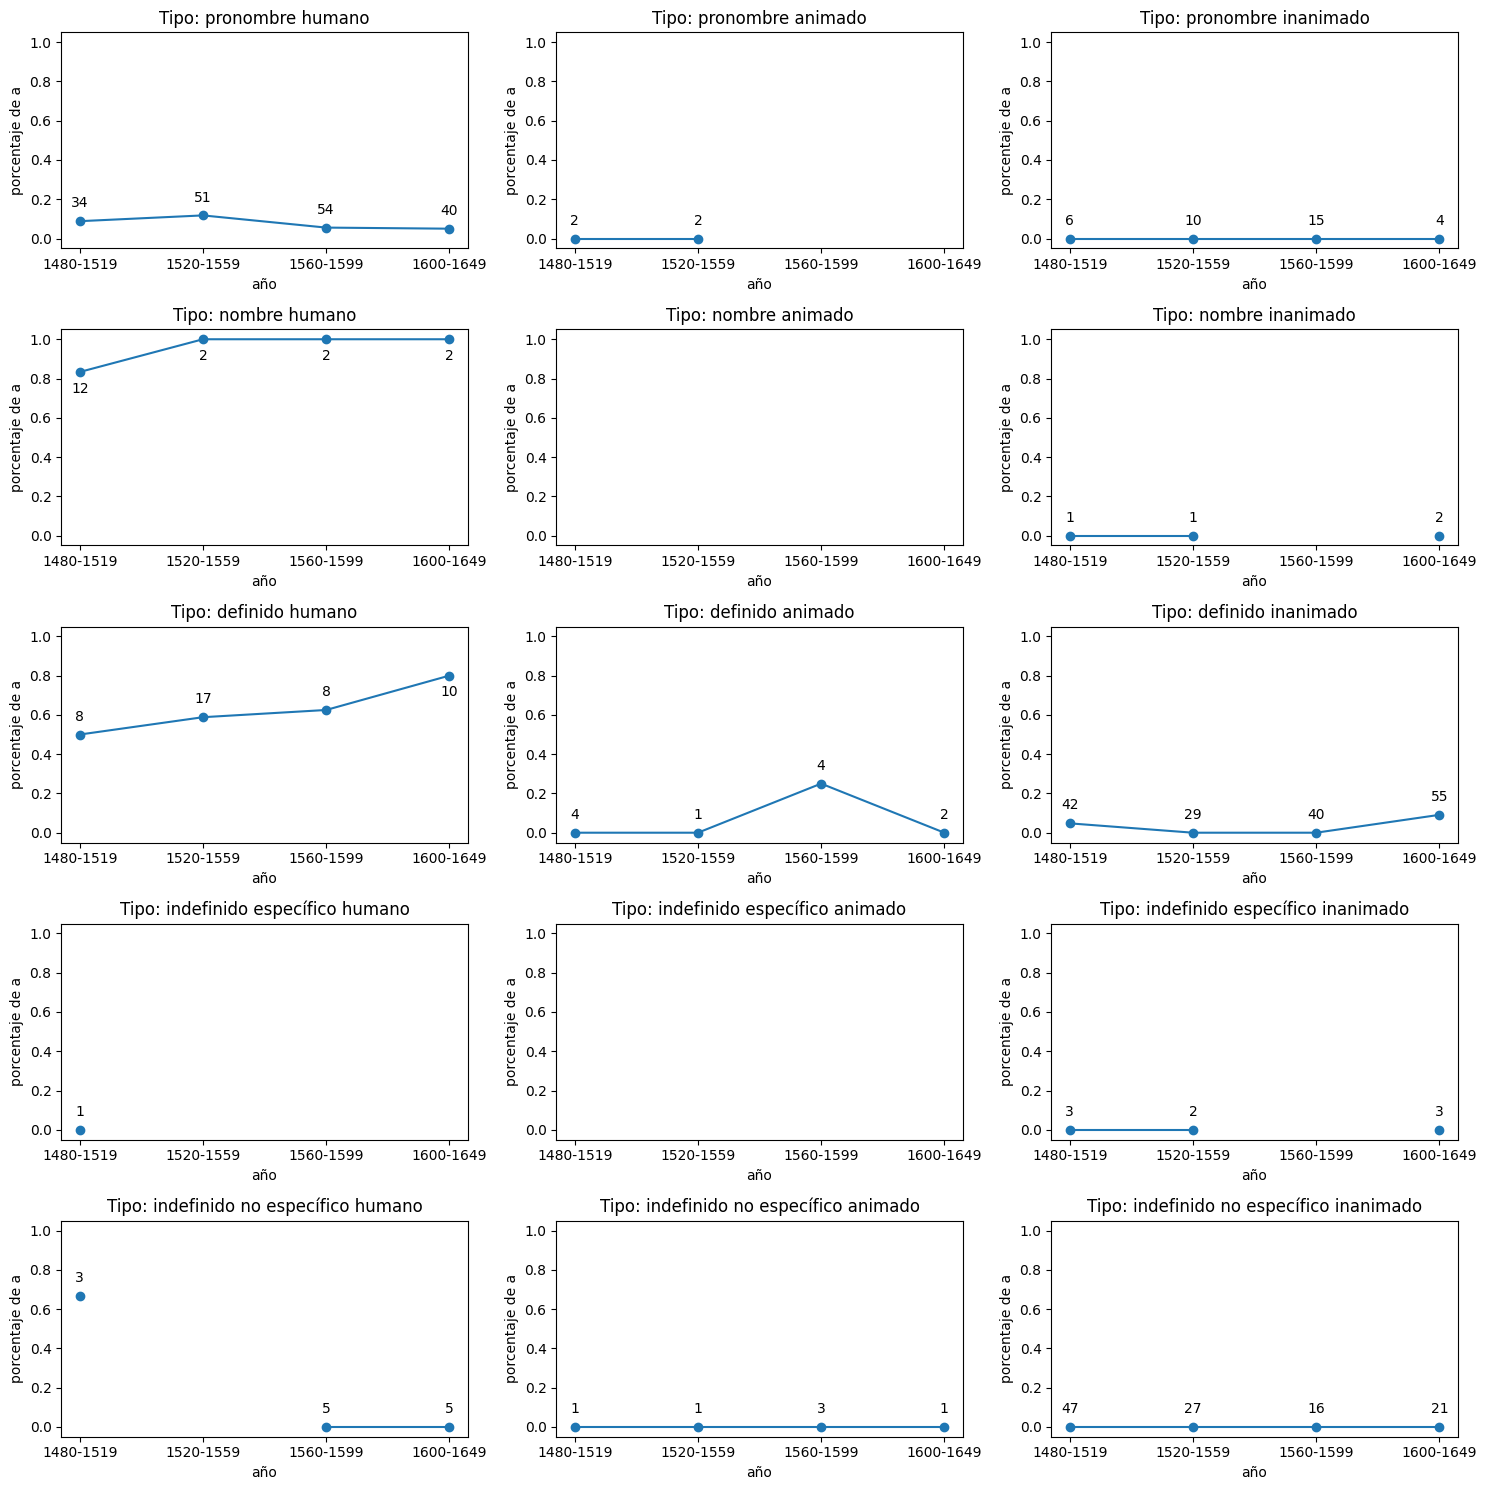

In [14]:
def set_plot_settings(ax, years, definiteness, animacy):
    dummy_data = [0.5 for year in years]
    ax.scatter([str(year) for year in years], dummy_data, color='white', lw=2.5, marker = 'o')
    ax.title.set_text("Tipo: " + plot_mapping[definiteness] + " " + plot_mapping[animacy])
    ax.set(xlabel="año", ylabel="porcentaje de a")
    ax.set_ylim(-0.05, 1.05)

def draw_plot(ax, years, definiteness, animacy, array, dataamounts):
    dummy_data = [0.5 for year in years]
    
    ax.plot([str(year) for year in years], array, lw=1.5, marker = 'o')
    for x,y,amount in zip([str(year) for year in years],array,dataamounts):
        if np.isnan(y):
            continue
        offset = (0,10)
        if y >= 0.8:
            offset = (0,-15)
        ax.annotate(str(amount), (x,y), textcoords="offset points", xytext=offset, ha='center')
    set_plot_settings(ax, years, definiteness, animacy)
    

def plot_percentage_a(df, years, ranges=True):
    fig, axs = plt.subplots(len(definiteness_categories[:-1]), len(animacy_categories[:-1]), figsize=(15,15))
    
    
    
    for i, definiteness in enumerate(definiteness_categories[:-1]):
        for j, animacy in enumerate(animacy_categories[:-1]):
            array = []
            dataamounts = []
            for year in years:
                #print(year)
                if ranges:
                    df_year = year.match_years(df)
                    #df_year = df[(df.loc[:, 'year'] >= year.start_year) & (df.loc[:, 'year'] <= year.end_year)]
                else:
                    df_year = df[df['year'] == year]
                
                
                # Check whether there is data
                percentage = calc_has_a_percentages(df_year, definiteness, animacy)
                array.append(percentage)
                dataamounts.append(calc_has_a_amount(df_year, definiteness, animacy))
                
            
            draw_plot(axs[i,j], years, definiteness, animacy, array, dataamounts)
            set_plot_settings(axs[i,j], years, definiteness, animacy)
            #axs[i,j].set_xticks(labels=years)
            #plot()
    fig.tight_layout()
    fig.savefig('percentagea.png')
    return

plot_percentage_a(df, year_ranges)

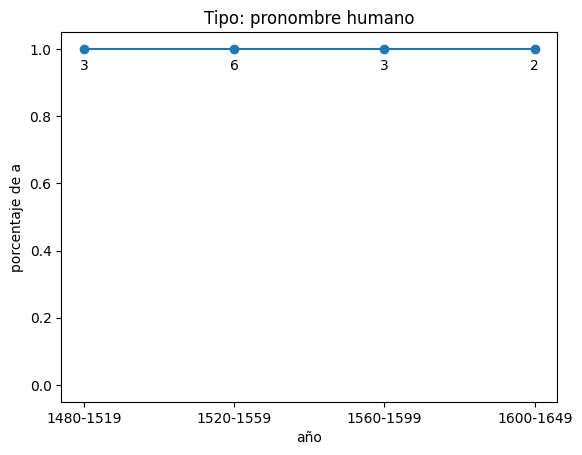

In [15]:
def plot_specific_graph(df, years, definiteness, animacy, plot_all = True, has_a = True):
    ax = plt.gca()
    array = []
    dataamounts = []
    for year in years:
        df_year = df[(df.loc[:, 'year'] >= year.start_year) & (df.loc[:, 'year'] <= year.end_year)]
        
        if not plot_all:
            df_year = df_year[df_year['has_a'] == has_a]
        
        # Check whether there is data
        percentage = calc_has_a_percentages(df_year, definiteness, animacy)
        array.append(percentage)
        dataamounts.append(calc_has_a_amount(df_year, definiteness, animacy))
    

    draw_plot(ax, years, definiteness, animacy, array, dataamounts)
    return

plot_specific_graph(df, year_ranges, 'Definiteness.pronoun', 'H', plot_all = False, has_a = True)


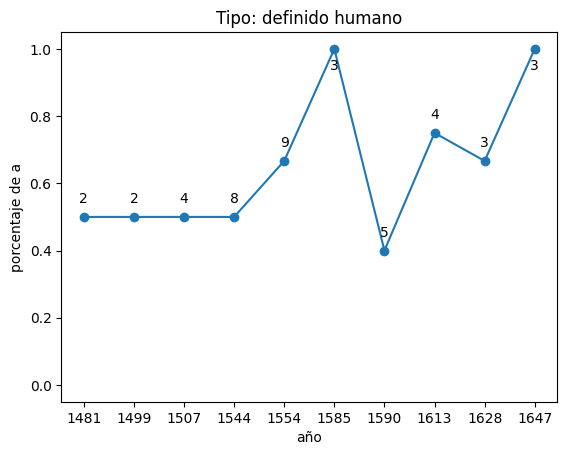

In [16]:
year_ranges_single = []
for year in years:
    year_ranges_single.append(YearRange(year, year))
    
plot_specific_graph(df, year_ranges_single, 'Definiteness.definite', 'H')

In [17]:
def get_df_part(df, defi, ani, print_all = True, a = False):
    mask = (df.loc[:, 'corrected_def'] == defi) & (df.loc[:, 'animacy'] == ani)
    
    if not print_all:
        if a:
            mask = mask & df.loc[:, 'has_a']
            #filtered_df = filt_df[df['has_a']]
        else:
            mask = mask & ~df.loc[:, 'has_a']
            #filtered_df = filt_df[~df['has_a']]
    
    filtered_df = df[mask]
    return filtered_df[['year', 'title', 'author', 'modern_sentence', 'has_a', 'verb', 'corrected_def', 'animacy', 'corrected_order']]



In [18]:
def check_sent(row, sent):
    return sent in row['modern_sentence']

def find_sentences(df, sent):
    #print(df['modern_sentence'])
    mask = df.apply(check_sent, args=(sent, ), axis=1)
    filtered_df = df[mask]
    return filtered_df[['year', 'title', 'author', 'modern_sentence', 'has_a', 'verb', 'animacy']]


# Inspect rare cases
The following cells all print parts of the dataframe to inspect odd cases in more detail

## Indefinite, nonspecific humans
We found very few cases of these but interestingly they are all over the map in terms of having or not having 'a'. We therefore print them.

In [19]:
pd.options.display.max_colwidth = 350
get_df_part(df, 'Definiteness.indef_nonspec', 'H')


,year,title,author,modern_sentence,has_a,verb,corrected_def,animacy,corrected_order
2,1499,La Celestina,Fernando Rojas,"habló con un criado suyo llamado Sempronio , el qual , después de muchas razones , le endereçó a una vieja llamada Celestina , en cuya casa tenía el mesmo criado una enamorada llamada Elicia.",False,tenía,Definiteness.indef_nonspec,H,VSO
4,1499,La Celestina,Fernando Rojas,"La qual , viniendo Sempronio a casa de Celestina con el negocio de su amo , tenía a otro consigo , llamado Crito , al qual escondieron.",True,llamado,Definiteness.indef_nonspec,H,VO
120,1499,La Celestina,Fernando Rojas,"- Torpe cosa es mentir el que enseña a otro , pues que tú te precias de loar a tu amiga Elicia.",True,enseña,Definiteness.indef_nonspec,H,SVO
167,1590,Comedia del Príncipe Ynocente,Lope de Vega,] allí llama un caminante.,False,llama,Definiteness.indef_nonspec,H,VO
201,1590,Comedia del Príncipe Ynocente,Lope de Vega,"] pues alto , deme la mano y hagamos cuatro testigos.",False,hagamos,Definiteness.indef_nonspec,H,VO
9,1585,Dialogo de la dignidad del hombre,Fernán Pérez de Oliva,"Paresciendo mal esta razón a Antonio , por no aver criatura más excelente que el hombre ni que más contentamiento deba tener por aver nacido , dize que le provará lo contrario.",False,aver,Definiteness.indef_nonspec,H,VO
14,1585,Dialogo de la dignidad del hombre,Fernán Pérez de Oliva,"junto a ella hallan un viejo muy sabio llamado Dinarco con otros estudiosos , y entendiendo la contienda y constituido por juez della manda a Aurelio que hable primero y luego Antonio diga su parecer.",False,hallan,Definiteness.indef_nonspec,H,VO
54,1585,Dialogo de la dignidad del hombre,Fernán Pérez de Oliva,"ésa tiene otros muchos amadores , como sabes , y pues es así , yo te ruego que me declares cuál es la causa , a tu parecer , por que los hombres aman la soledad y tanto más cuanto son más sabios.",False,tiene,Definiteness.indef_nonspec,H,SVO
3,1628,La cueva de Salamanca,Juan Ruiz de Alarcón y Mendoza,"Si ver mugeres ordeno , ninguna tiene buen talle , si andar de noche en la calle , os haze mal el sereno.",False,ver,Definiteness.indef_nonspec,H,VO
8,1628,La cueva de Salamanca,Juan Ruiz de Alarcón y Mendoza,"pese a tal , don Iuan , con vos , haced tal vez lo que quiero , o buscad un compañero hermano de Iuan de Dios.",False,buscad,Definiteness.indef_nonspec,H,VO


In [20]:
# check the 'a otro'
find_sentences(complete_df, "a otro")

,year,title,author,modern_sentence,has_a,verb,animacy
118,1481,Laberinto de Fortuna,Juan de Mena,"Así razonando , la puerta pasamos , por do confluía tamaño gentío que allí do el ingresso más era vacío unos a otros estorbo nos damos , ca por la cosa que mucho andamos quanto deseo común más se esfuerza , más nuestra prisa nos daña e nos fuerça , e lo que queremos menos acabamos.",False,damos,NaN
119,1481,Laberinto de Fortuna,Juan de Mena,"Así razonando , la puerta pasamos , por do confluía tamaño gentío que allí do el ingresso más era vacío unos a otros estorbo nos damos , ca por la cosa que mucho andamos quanto deseo común más se esfuerza , más nuestra prisa nos daña e nos fuerça , e lo que queremos menos acabamos.",False,deseo,NaN
120,1481,Laberinto de Fortuna,Juan de Mena,"Así razonando , la puerta pasamos , por do confluía tamaño gentío que allí do el ingresso más era vacío unos a otros estorbo nos damos , ca por la cosa que mucho andamos quanto deseo común más se esfuerza , más nuestra prisa nos daña e nos fuerça , e lo que queremos menos acabamos.",False,esfuerza,NaN
121,1481,Laberinto de Fortuna,Juan de Mena,"Así razonando , la puerta pasamos , por do confluía tamaño gentío que allí do el ingresso más era vacío unos a otros estorbo nos damos , ca por la cosa que mucho andamos quanto deseo común más se esfuerza , más nuestra prisa nos daña e nos fuerça , e lo que queremos menos acabamos.",False,daña,NaN
122,1481,Laberinto de Fortuna,Juan de Mena,"Así razonando , la puerta pasamos , por do confluía tamaño gentío que allí do el ingresso más era vacío unos a otros estorbo nos damos , ca por la cosa que mucho andamos quanto deseo común más se esfuerza , más nuestra prisa nos daña e nos fuerça , e lo que queremos menos acabamos.",False,fuerça,NaN
...,...,...,...,...,...,...,...
1288,1613,Novela de la Illustre Fregona,Miguel de Cervantes Saavedra,al momento la mudaron a otro aposento que está aquí arriba apartado y con la comodidad que el doctor pedía.,False,mudaron,NaN
1289,1613,Novela de la Illustre Fregona,Miguel de Cervantes Saavedra,al momento la mudaron a otro aposento que está aquí arriba apartado y con la comodidad que el doctor pedía.,False,pedía,NaN
1582,1613,Novela de la Illustre Fregona,Miguel de Cervantes Saavedra,"Esta señora se mudó de aquel lugar a otro , y sin que yo jamás la viese , ni lo procurase , se pasaron dos años , al cabo de los quales supe que era muerta;",False,mudó,NaN
1583,1613,Novela de la Illustre Fregona,Miguel de Cervantes Saavedra,"Esta señora se mudó de aquel lugar a otro , y sin que yo jamás la viese , ni lo procurase , se pasaron dos años , al cabo de los quales supe que era muerta;",False,procurase,NaN


## Human names without a
We only found this in the first time period, so it seems worthwhile to check out



In [21]:
get_df_part(df, 'Definiteness.name', 'H', print_all = False)

,year,title,author,modern_sentence,has_a,verb,corrected_def,animacy,corrected_order
247,1481,Laberinto de Fortuna,Juan de Mena,"también en la rueda vimos sublimada , llena de méritos muchos , a Argía , e vi que la parte derecha tenía Alcides cuasi del todo ocupada , a fuero de montero , con maza clavada , bien como quando librava en el siglo los calidones del bravo vestiglo e la real mesa de ser ensuziada.",False,librava,Definiteness.name,H,VO
52,1499,La Celestina,Fernando Rojas,"aunque por al no desease viuir , sino por ver mi Elicia , me deuría guardar de peligros.",False,ver,Definiteness.name,H,VO


## Definite humans without a

In [22]:
df_defhum = get_df_part(df, 'Definiteness.definite', 'H', print_all = False)
df_defhum

,year,title,author,modern_sentence,has_a,verb,corrected_def,animacy,corrected_order
808,1481,Laberinto de Fortuna,Juan de Mena,"e vi los que reinan en paz glorïosa e los muy humanos a sus naturales , e muchos de aquellos , siendo mortales , viven çelando la pública cosa;",False,vi,Definiteness.definite,H,VO
13,1544,Dialogo de mujeres,Cristóbal de Castillejo,"Porque luego que crió Dios la primera muger , por su culpa aquel placer ya veis quán poco duró.",False,crió,Definiteness.definite,H,VSO
44,1544,Dialogo de mujeres,Cristóbal de Castillejo,"Quando Dios lo crió todo y formó el hombre primero , ya veis que como a grosero lo hizo de puro lodo;",False,formó,Definiteness.definite,H,VO
95,1544,Dialogo de mujeres,Cristóbal de Castillejo,"Pues si Dios con su sapiencia las mugeres ordenó , no sin causa nos las dio.",False,ordenó,Definiteness.definite,H,SOV
141,1544,Dialogo de mujeres,Cristóbal de Castillejo,"De aquí viene que si algún príncipe tiene desmandados apetitos , suele jugar a dos hitos sin que nadie le condene , y assí habría cien mill otros a porfía que , si osassen , dexarían sus mugeres e harían nueva ley de bigamía.",False,dexarían,Definiteness.definite,H,VO
113,1499,La Celestina,Fernando Rojas,Mandaste al hombre por la muger dexar el padre e la madre;,False,dexar,Definiteness.definite,H,VO
20,1507,Representación sobre el poder del amor,Juan del Encina,Yo sostengo los penados esperando gualardones.,False,sostengo,Definiteness.definite,H,SVO
33,1507,Representación sobre el poder del amor,Juan del Encina,tengo casi todo el mundo por entero por vasallo y prisionero:,False,tengo,Definiteness.definite,H,VO
94,1590,Comedia del Príncipe Ynocente,Lope de Vega,"Despedid esa gente de la plaza , que ya la caza aquésta vez suspendo.",False,despedid,Definiteness.definite,H,VO
96,1590,Comedia del Príncipe Ynocente,Lope de Vega,"] Antes os ruego no dejéis la caza , que de camino estoy , y iré sirviendo aquestas damas.",False,ruegoiré sirviendo,Definiteness.definite,H,VO


In [23]:
df_defhum['title'].value_counts()

Dialogo de mujeres                        4
Comedia del Príncipe Ynocente             3
Farsa de la muerte                        3
Representación sobre el poder del amor    2
Laberinto de Fortuna                      1
La Celestina                              1
La cueva de Salamanca                     1
Novela de la Illustre Fregona             1
Name: title, dtype: int64

In [24]:

for year in year_ranges:
    year.match_years(df_defhum)

In [25]:
df_defhumall = get_df_part(df, 'Definiteness.definite', 'H', print_all = True)[['year', 'has_a']]
df_defhumall.corr()

,year,has_a
year,1.000000,0.216497
has_a,0.216497,1.000000


## Pronoun human with a
We need to annotate this group separately because of the complicated occasional doubling of the object. This is easiest done by just exporting these cases and then annotating them. The first block exports and the second block imports again. The third block calculates a cross-table to help interpret the data. 

In [26]:
humanprona = get_df_part(df, 'Definiteness.pronoun', 'H', print_all = False, a = True)
humanprona.to_csv('HumanPronounA.tsv', sep="\t")
humanprona

,year,title,author,modern_sentence,has_a,verb,corrected_def,animacy,corrected_order
240,1481,Laberinto de Fortuna,Juan de Mena,"ti , muger vimos del gran Mauseolo , tú que con lágrimas nos profetizas , las maritales regando çenizas , vicio ser viuda de más de uno solo;",True,muger,Definiteness.pronoun,H,OV
18,1544,Dialogo de mujeres,Cristóbal de Castillejo,"por qué no le tentó a él , sino por verle leal y constante?,",True,tentó,Definiteness.pronoun,H,OVO
1130,1544,Dialogo de mujeres,Cristóbal de Castillejo,"dejadlo quedar ay , que otro día hablaremos , y solamente hablemos de lo que me toca a mí por agora , y de aquella mi señora que os decía , y sus amores , dinos y mereçedores de quien los ama y adora , porque son de extremada perfección , dulces , graçiosos y bellos , y os quiero dar cuenta de ellos para mi consolaçión.",True,toca,Definiteness.pronoun,H,SOVO
11,1499,La Celestina,Fernando Rojas,"- En dar poder a natura que de tan perfecta hermosura te dotasse e facer a mí inmérito tanta merced que verte alcanzase e en tan conveniente lugar , que mi secreto dolor manifestarte pudiesse.",True,facer,Definiteness.pronoun,H,VO
144,1507,Representación sobre el poder del amor,Juan del Encina,Cómo te llaman a ti?,True,llaman,Definiteness.pronoun,H,OVO
116,1590,Comedia del Príncipe Ynocente,Lope de Vega,"] a mí , señor , me pesara , y agradézcole el favor , que estaban ya de partida las damas , y no era justo estorvarles tanto gusto dando enojo mi venida.",True,pesara,Definiteness.pronoun,H,NaN
196,1590,Comedia del Príncipe Ynocente,Lope de Vega,quién os mete en eso a vos?,True,mete,Definiteness.pronoun,H,NaN
83,1585,Dialogo de la dignidad del hombre,Fernán Pérez de Oliva,"porque , mirando yo a ellos como a principales del género humano , nunca he visto cosa por do tuviese esperança que pueda venir el hombre a algún estado donde no le fuera mejor no ser nacido.",True,mirando,Definiteness.pronoun,H,VO
41,1554,Farsa de la muerte,Diego Sánchez de Badajoz,esto es lo que a mí me pesa:,True,pesa,Definiteness.pronoun,H,OOV
47,1554,Farsa de la muerte,Diego Sánchez de Badajoz,"soy como los pedricones , que a los que están nos sermones riñen con los que no están.",True,riñen,Definiteness.pronoun,H,SOV


In [27]:
humanprona_annotated = pd.read_csv('HumanPronounAAnnotated.tsv', dtype=str, sep='\t')
humanprona_annotated['has_a'] = humanprona_annotated.apply(strToBool, axis=1)
humanprona_annotated['double'] = humanprona_annotated.apply(strToBool, args=('double', ), axis=1)
humanprona_annotated['year'] = humanprona_annotated.apply(strToInt, axis=1)
humanprona_annotated


,Unnamed: 0,year,title,author,modern_sentence,has_a,verb,corrected_def,animacy,corrected_order,order_of_a,double
0,240,1481,Laberinto de Fortuna,Juan de Mena,"A ti , muger vimos del gran Mauseolo , tú que con lágrimas nos profetizas , las maritales regando çenizas , vicio ser viuda de más de uno solo;",True,muger,Definiteness.pronoun,H,OV,OV,False
1,18,1544,Dialogo de mujeres,Cristóbal de Castillejo,"por qué no le tentó a él , sino por verle leal y constante?,",True,tentó,Definiteness.pronoun,H,OVO,VO,True
2,1130,1544,Dialogo de mujeres,Cristóbal de Castillejo,"dejadlo quedar ay , que otro día hablaremos , y solamente hablemos de lo que me toca a mí por agora , y de aquella mi señora que os decía , y sus amores , dinos y mereçedores de quien los ama y adora , porque son de extremada perfección , dulces , graçiosos y bellos , y os quiero dar cuenta de ellos para mi consolaçión.",True,toca,Definiteness.pronoun,H,SOVO,VO,True
3,11,1499,La Celestina,Fernando Rojas,"- En dar poder a natura que de tan perfecta hermosura te dotasse e facer a mí inmérito tanta merced que verte alcanzase e en tan conveniente lugar , que mi secreto dolor manifestarte pudiesse.",True,facer,Definiteness.pronoun,H,VO,VO,False
4,144,1507,Representación sobre el poder del amor,Juan del Encina,Cómo te llaman a ti?,True,llaman,Definiteness.pronoun,H,NaN,VO,True
5,116,1590,Comedia del Príncipe Ynocente,Lope de Vega,"] a mí , señor , me pesara , y agradézcole el favor , que estaban ya de partida las damas , y no era justo estorvarles tanto gusto dando enojo mi venida.",True,pesara,Definiteness.pronoun,H,NaN,OV,True
6,196,1590,Comedia del Príncipe Ynocente,Lope de Vega,quién os mete en eso a vos?,True,mete,Definiteness.pronoun,H,NaN,VO,True
7,83,1585,Dialogo de la dignidad del hombre,Fernán Pérez de Oliva,"porque , mirando yo a ellos como a principales del género humano , nunca he visto cosa por do tuviese esperança que pueda venir el hombre a algún estado donde no le fuera mejor no ser nacido.",True,mirando,Definiteness.pronoun,H,VO,VO,False
8,41,1554,Farsa de la muerte,Diego Sánchez de Badajoz,esto es lo que a mí me pesa:,True,pesa,Definiteness.pronoun,H,OOV,OV,True
9,47,1554,Farsa de la muerte,Diego Sánchez de Badajoz,"soy como los pedricones , que a los que están nos sermones riñen con los que no están.",True,riñen,Definiteness.pronoun,H,SOV,OV,False


In [28]:
contingency= pd.crosstab(humanprona_annotated['order_of_a'], humanprona_annotated['double'], margins=True)
contingency

double,False,True,All
order_of_a,,,
OV,2,3,5
VO,2,7,9
All,4,10,14


In [29]:
c, p, dof, expected = chi2_contingency(contingency)
print(c, p, dof)

print(contingency.to_latex())

0.49777777777777776 0.9737169515224636 4
\begin{tabular}{lrrr}
\toprule
double &  False &  True &  All \\
order\_of\_a &        &       &      \\
\midrule
OV         &      2 &     3 &    5 \\
VO         &      2 &     7 &    9 \\
All        &      4 &    10 &   14 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_149941/3747160652.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(contingency.to_latex())


## Definite inanimate with a

In [30]:
get_df_part(df, 'Definiteness.definite', 'I', print_all = False, a = True)

,year,title,author,modern_sentence,has_a,verb,corrected_def,animacy,corrected_order
38,1481,Laberinto de Fortuna,Juan de Mena,"Como las nautas que van en poniente fallan en Cádiz la mar sin repunta , Europa por pocas con Libia que junta , quando Boreas se muestra valiente , pero si el Austro comueve al tridente , corren en contra de como vinieron las aguas , que nunca tendrán ni tuvieron allí , donde digo , reposo paçiente , así fluctuosos , Fortuna aborrida , tus cas...",True,comueve,Definiteness.definite,I,NaN
7,1507,Representación sobre el poder del amor,Juan del Encina,"mi guerra nunca sosiega , mis artes , fuerzas y mañas , y mis sañas , mis bravezas , mis enojos , quando encaran a los ojos luego enclavan las entrañas.",True,encaran,Definiteness.definite,I,NaN
16,1647,Oráculo manual y arte de prudencia,Baltasar Gracián,"Por esto , y porque no se oponen a las regalías del rey Nuestr o Señor , pueden darsela a la prensa.",True,oponen,Definiteness.definite,I,VO
53,1647,Oráculo manual y arte de prudencia,Baltasar Gracián,"Es robarle a la esperança cortés fiar del agradecimiento villano , que lo que aquélla es memoriosa es éste olvidadizo.",True,robarle,Definiteness.definite,I,VO
61,1647,Oráculo manual y arte de prudencia,Baltasar Gracián,"pero no se ha de regar al exceso de callar para que yerre , ni hazer incurable el daño ageno por el provecho propio.",True,regar,Definiteness.definite,I,VO
79,1628,La cueva de Salamanca,Juan Ruiz de Alarcón y Mendoza,"Repartidos nos pongamos , y el que viere a la justicia , a los otros dè noticia , para que el ruido hagamos.",True,viere,Definiteness.definite,I,NaN
89,1613,Novela de la Illustre Fregona,Miguel de Cervantes Saavedra,"no quiso Carriazo tenersela encubierta , por no hacer agravio a la grande amistad que professauan;",True,hacer agravio,Definiteness.definite,I,NaN


# Produce word order graphs

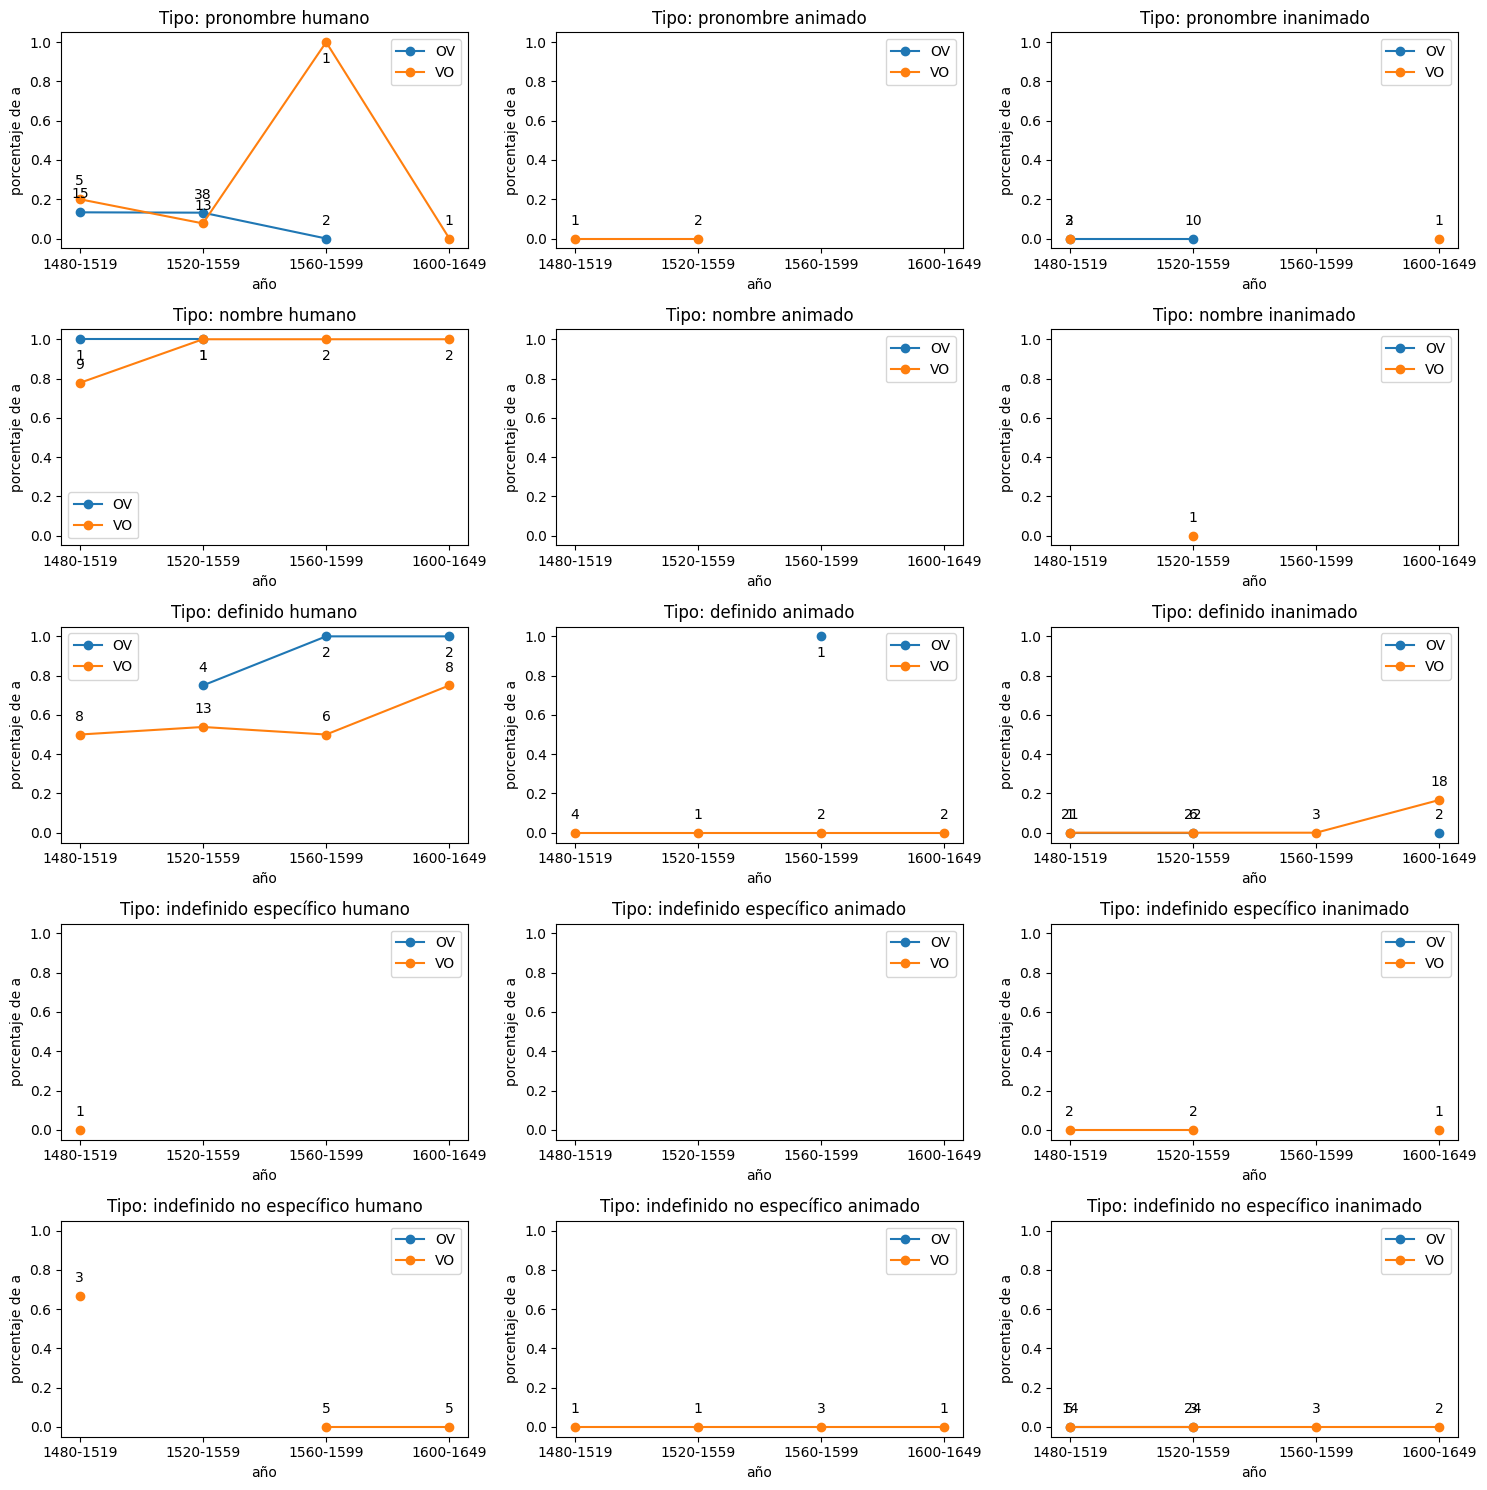

In [31]:
def select(year, VO: bool):
    if VO:
        condition = lambda item: isinstance(item, str) and item.index('O') > item.index('V')
    else:
        condition = lambda item: isinstance(item, str) and item.index('O') < item.index('V')
    return lambda df: (df['year'] >= year.start_year) & (df['year'] <= year.end_year) & (df['corrected_order'].apply(condition))

def draw_order_graph(ax, df, years, definiteness, animacy, ranges=True):
    dummy_data = [0.5 for year in years]
    
    OVArray = []
    VOArray = []
    dataamountsVO = []
    dataamountsOV = []
    
    for year in years:
        #print(year)
        if ranges:
            df_year_VO = df.loc[select(year, True), :]
            df_year_OV = df.loc[select(year, False), :]
        else:
            year_range = YearRange(year, year)
            df_year_VO = df[select(year_range, True), :]
            df_year_OV = df[select(year_range, False), :]
        VOArray.append(calc_has_a_percentages(df_year_VO, definiteness, animacy))
        OVArray.append(calc_has_a_percentages(df_year_OV, definiteness, animacy))
        dataamountsVO.append(len(get_df_part(df_year_VO, definiteness, animacy)))
        dataamountsOV.append(len(get_df_part(df_year_OV, definiteness, animacy)))
        #dataamountsVO.append(calc_has_a_amount(df_year_VO, definiteness, animacy))
        #dataamountsOV.append(calc_has_a_amount(df_year_OV, definiteness, animacy))
    if ranges:
        ax.plot([str(year) for year in years], OVArray, lw=1.5, marker = 'o', label="OV")
        ax.plot([str(year) for year in years], VOArray, lw=1.5, marker = 'o', label="VO")
    else:
        ax.plot(years, OVArray, lw=1.5, marker = 'o', label="OV")
        ax.plot(years, VOArray, lw=1.5, marker = 'o', label="VO")

    for x, yVO, yOV, amountVO, amountOV in zip([str(year) for year in years],VOArray,OVArray,dataamountsVO, dataamountsOV):
        if not np.isnan(yOV):
            offset = (0,10)
            if yOV >= 0.8:
                offset = (0,-15)
            ax.annotate(str(amountOV), (x,yOV), textcoords="offset points", xytext=offset, ha='center')
        if not np.isnan(yVO):
            offset = (0,10)
            if yVO >= 0.8:
                offset = (0,-15)
            ax.annotate(str(amountVO), (x,yVO), textcoords="offset points", xytext=offset, ha='center')

    set_plot_settings(ax, years, definiteness, animacy)
    ax.legend()

def plot_all(df, years, ranges=True):
    fig, axs = plt.subplots(len(definiteness_categories[:-1]), len(animacy_categories[:-1]), figsize=(15,15))
    

    
    for i, definiteness in enumerate(definiteness_categories[:-1]):
        for j, animacy in enumerate(animacy_categories[:-1]):
            draw_order_graph(axs[i,j], df, years, definiteness, animacy, ranges)
            #axs[i,j].set_xticks(labels=years)
            #plot()
    fig.tight_layout()
    fig.savefig('img.png')
    return

plot_all(df, year_ranges)

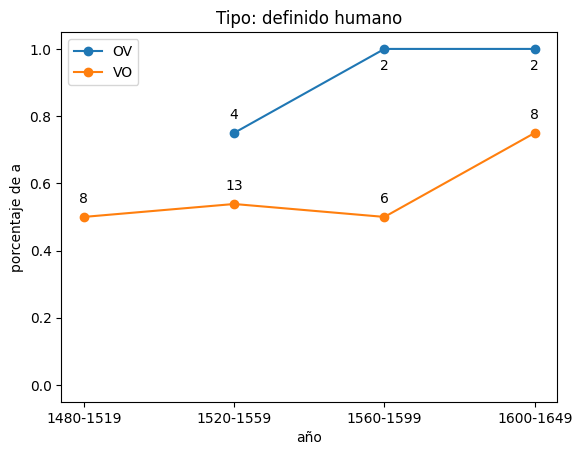

In [32]:
def plot_order_graph(df, years, definiteness, animacy, ranges=True):
    ax = plt.gca()
    draw_order_graph(ax, df, years, definiteness, animacy, ranges=ranges)

plot_order_graph(df, year_ranges, 'Definiteness.definite', 'H')


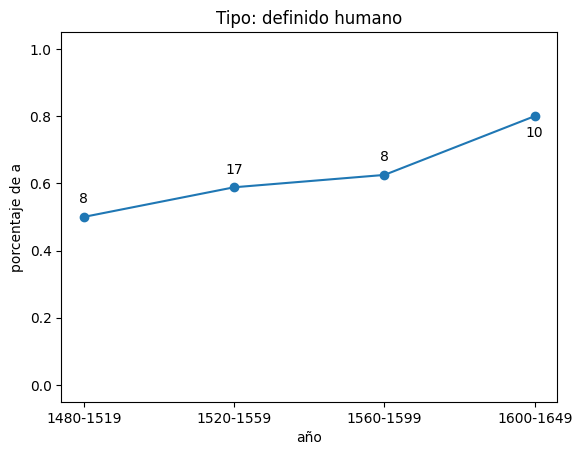

In [33]:
plot_specific_graph(df, year_ranges, 'Definiteness.definite', 'H')


In [34]:
def is_order_annotated(row):
    return isinstance(row['corrected_order'], str) and'V' in row['corrected_order'] and 'O' in row['corrected_order']

def find_order(row):
    item = row['corrected_order']
    if item.index('O') > item.index('V'):
        return 'OV'
    elif item.index('O') < item.index('V'):
        return 'VO'
    else:
        return 'Problem'

    
df_filt = get_df_part(df, 'Definiteness.definite', 'H', print_all = True)

# Chi squared?
mask = df_filt.apply(is_order_annotated, axis=1)
df_order_annotated = df_filt[mask]
#print(df_order_annotated)
df_order_annotated['VO_OV'] = df_order_annotated.apply(find_order, axis=1)
#print(df_order_annotated)
#order = df_order_annotated['corrected_order'].apply(lambda item: isinstance(item, str) and item.index('O') > item.index('V'))
#print(order)


# Only human definite

contingency= pd.crosstab(df_order_annotated['VO_OV'], df_order_annotated['has_a'])
print(contingency)

c, p, dof, expected = chi2_contingency(contingency)
print(c, p, dof)

has_a  False  True 
VO_OV              
OV        15     20
VO         1      7
1.433422205687831 0.23120674371961733 1
